In [181]:
# Change this to whatever your directory you're working from is - this should be
# the head level with Code and Data directories.
main_path = '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/'

In [282]:
import matplotlib.pyplot as plt
import pandas as pd
import keras
import numpy as np
from keras import models
from keras import layers
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
import copy
import random as python_random
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint
from google.colab import files
import sklearn.preprocessing
import scipy

import sys
import importlib

# set seeds
np.random.seed(768)
python_random.seed(869)
tf.random.set_seed(1234)

from google.colab import drive
drive.mount('/content/drive')

sys.path.append(main_path+"Code")

# This is our library of class functions
import vep
importlib.reload(vep)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
clinvar_seq_preprocessing.ipynb
generate_full_length_encodings.ipynb
model1_train_aa_subs_model.ipynb
model2_train_window_seq_vep_model.ipynb
model3_train_full_length_alley2019_model.ipynb
__pycache__
vep_functions.py
vep.py


<module 'vep' from '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/Code/vep.py'>

In [271]:
x = np.zeros((24,2))
x[0] = np.array([1,1])
x

array([[1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [283]:
# Now, let's load our train and validate sets
data_dir = main_path+'Data/'
window_size = 6
train_file = data_dir+'train_processed_clinvar_seqs_with_clusters_clustershuffle.csv'
val_file = data_dir+'validate_processed_clinvar_seqs_with_clusters_clustershuffle.csv'
test_file = data_dir+'test_processed_clinvar_seqs_with_clusters_clustershuffle.csv'

# Initiate an instance of my Model2 class
m2 = vep.Model2(data_dir+'precursor_files/amino_acid_properties.csv')

# Process our input and output data
m2.process_input_and_output_training(train_file,val_file,test_file,window_size=window_size,return_out=False)

The categories are: [array(['benign', 'pathogenic'], dtype='<U10')]


In [320]:
X_train = m2.X_train
input_size = X_train.shape
x = X_train.reshape(input_size[0]*input_size[1],input_size[2])
print(x[0])
scaler = sklearn.preprocessing.MinMaxScaler()
scaler = scaler.fit(x)
x = scaler.transform(x).reshape(input_size[0],input_size[1],input_size[2])

X_val = m2.X_val
input_size = X_val.shape
xv = X_val.reshape(input_size[0]*input_size[1],input_size[2])
print(xv[0])
xv = scaler.transform(xv).reshape(input_size[0],input_size[1],input_size[2])
#x[0]


[ -3.5   132.119   3.93    5.41    0.      0.      0.      0.   ]
[ -3.2   155.156   2.26    7.59    0.      0.      0.      0.   ]


In [295]:
X_train[0][0]

array([ -3.5  , 132.119,   3.93 ,   5.41 ,   0.   ,   0.   ,   0.   ,
         0.   ])

In [302]:
X_train[0][4]

array([  3.8  , 131.175,   9.68 ,   5.98 ,   0.   ,   0.   ,   0.   ,
         0.   ])

In [303]:
x[0][0][4:]

array([0.5, 0. , 0. , 0. ])

In [322]:
n_features = 8
n_timesteps = 2*window_size + 1

# Let's make our bi-directional GRU-based model
model_gru = models.Sequential()
model_gru.add(layers.Bidirectional(GRU(10, activation='relu', input_shape=(n_timesteps,n_features),kernel_regularizer=regularizers.L2(l2=0.00005))))
model_gru.add(layers.Dense(5,activation='relu'))
model_gru.add(layers.Dense(2, activation='softmax')) 
 
nepochs = 150

model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics='categorical_accuracy')

history = model_gru.fit(x, m2.Y_train,
          epochs=nepochs,
          batch_size=512,
          validation_data=(xv, m2.Y_val)
)

print(model_gru.summary())

Epoch 1/150
10/10 [==============================] - 4s 66ms/step - loss: 0.6650 - categorical_accuracy: 0.6131 - val_loss: 0.6270 - val_categorical_accuracy: 0.6793
Epoch 2/150
10/10 [==============================] - 0s 18ms/step - loss: 0.6554 - categorical_accuracy: 0.6155 - val_loss: 0.6202 - val_categorical_accuracy: 0.6793
Epoch 3/150
10/10 [==============================] - 0s 18ms/step - loss: 0.6424 - categorical_accuracy: 0.6247 - val_loss: 0.6027 - val_categorical_accuracy: 0.6843
Epoch 4/150
10/10 [==============================] - 0s 19ms/step - loss: 0.6279 - categorical_accuracy: 0.6524 - val_loss: 0.5932 - val_categorical_accuracy: 0.6919
Epoch 5/150
10/10 [==============================] - 0s 19ms/step - loss: 0.6173 - categorical_accuracy: 0.6622 - val_loss: 0.5932 - val_categorical_accuracy: 0.6894
Epoch 6/150
10/10 [==============================] - 0s 20ms/step - loss: 0.6206 - categorical_accuracy: 0.6582 - val_loss: 0.6027 - val_categorical_accuracy: 0.6768
Epoc

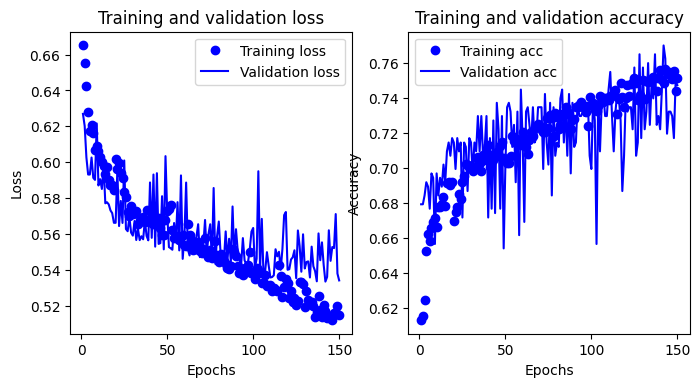

In [323]:
m2.nn_model = model_gru
m2.nn_history = history

m2.plot_accuracy_and_loss()

In [324]:
model_gru.save_weights(main_path+'Code/Trained_Model_Weights/model2_clustershuffled.h5')